<a href="https://colab.research.google.com/github/kevinnaufaldany/candlestick-shape-analysis/blob/main/candle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code

Saving colab-access-457713-ba627f260d6c.json to colab-access-457713-ba627f260d6c (4).json


Dropdown(description='Pilih Tanggal:', options=('2025-02-10', '2025-02-11', '2025-02-12', '2025-02-13', '2025-…

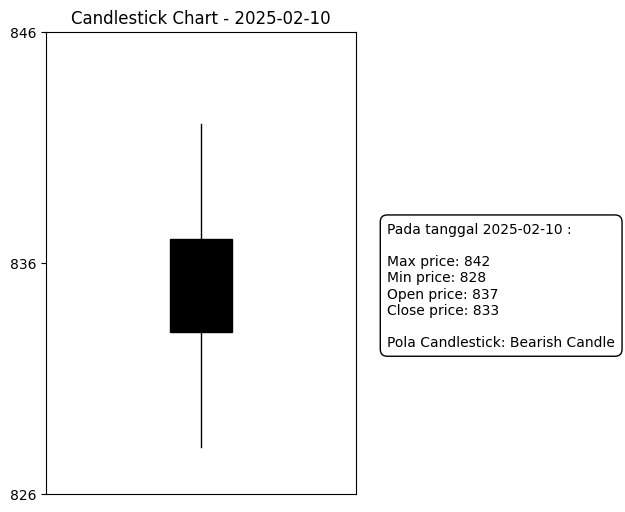

Button(description='Download Chart', style=ButtonStyle())

<Figure size 640x480 with 0 Axes>

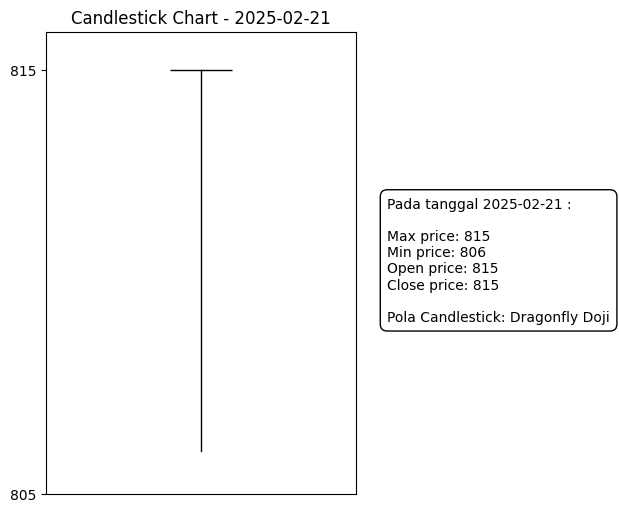

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Image
import pandas as pd
from google.colab import files
import gspread
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
import ipywidgets as widgets

# Fungsi untuk mendeteksi pola candlestick (Diperbarui)
def detect_candlestick_pattern(open_price, close_price, max_price, min_price):
    # Hitung body dan shadow
    body = abs(close_price - open_price)
    upper_shadow = max_price - max(open_price, close_price)
    lower_shadow = min(open_price, close_price) - min_price
    total_range = max_price - min_price

    # Tentukan apakah candle bullish atau bearish
    is_bullish = close_price > open_price
    is_bearish = close_price < open_price
    is_hammer = close_price == max_price
    is_hangiing_man = open_price == max_price
    is_inverted_hammer = open_price == min_price
    is_shooting_star = close_price == min_price
    is_marubozu = lower_shadow == 0 and upper_shadow == 0
    is_doji = body == 0
    is_four_price_doji = max_price == 0 and min_price == 0
    is_dragonfly_dogi = max_price == close_price and open_price
    is_gravestone_doji = min_price == close_price and open_price

    # 1. Deteksi Doji Patterns
    if is_four_price_doji:
        return "Four Price Doji"
    elif is_dragonfly_dogi:
        return "Dragonfly Doji"
    elif is_gravestone_doji:
        return "Gravestone Doji"
    elif is_doji:  # Body sangat kecil untuk semua Doji
        return "Doji"  # Default Doji jika tidak ada pola spesifik

    # 4. Deteksi Marubozu Patterns
    if is_marubozu:  # Shadow sangat kecil atau tidak ada
        if is_bullish:
            return "Marubozu Bullish"
        else:
            return "Marubozu Bearish"

    # 2. Deteksi Hammer Patterns (Hammer, Hanging Man)
    if is_hammer:
        return "Hammer"
    elif is_hangiing_man:
        return "Hanging Man"
    elif is_inverted_hammer:
        return "Inverted Hammer"
    elif is_shooting_star:
        return "Shooting Star"


    # Default: Jika tidak ada pola spesifik yang terdeteksi
    if is_bullish:
        return "Bullish Candle"
    else:
        return "Bearish Candle"

# Autentikasi untuk mengakses Google Spreadsheet
# Unggah file JSON kredensial ke Colab
uploaded = files.upload()  # Unggah file JSON yang Anda unduh dari Google Cloud

# Ambil nama file JSON
json_file_name = list(uploaded.keys())[0]

# Atur kredensial
scopes = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive"]
creds = Credentials.from_service_account_file(json_file_name, scopes=scopes)
client = gspread.authorize(creds)

# Buka spreadsheet menggunakan Spreadsheet ID
try:
    # Ganti 'SPREADSHEET_ID' dengan ID spreadsheet Anda
    spreadsheet = client.open_by_key('abcdefghijklmnopqrstuvwxyz1234567890')  # Masukkan Spreadsheet ID Anda di sini
    sheet = spreadsheet.sheet1  # Ambil sheet pertama
except gspread.exceptions.SpreadsheetNotFound:
    print("Error: Spreadsheet tidak ditemukan. Pastikan Spreadsheet ID benar dan sudah dibagikan dengan email service account.")
    raise

# Ambil data dari spreadsheet
try:
    data = sheet.get_all_records()
    df = pd.DataFrame(data)
except Exception as e:
    print(f"Error saat mengambil data: {e}")
    raise

# Pastikan kolom ada dan dalam tipe numerik
try:
    df['open_price'] = pd.to_numeric(df['open_price'])
    df['close_price'] = pd.to_numeric(df['close_price'])
    df['max_price'] = pd.to_numeric(df['max_price'])
    df['min_price'] = pd.to_numeric(df['min_price'])
except KeyError as e:
    print(f"Error: Kolom {e} tidak ditemukan. Pastikan kolom bernama 'date', 'open_price', 'close_price', 'max_price', dan 'min_price' ada di spreadsheet.")
    raise

# Fungsi untuk membuat candlestick chart
def create_candlestick(max_price, min_price, open_price, close_price, date, pattern):
    # Bersihkan plot sebelumnya
    plt.clf()

    # Buat figure dan axis
    fig, ax = plt.subplots(figsize=(4, 6))

    # Tentukan warna candlestick
    if open_price > close_price:
        # Harga naik: Candlestick putih
        candle_color = 'black'
    elif open_price < close_price:
        # Harga turun: Candlestick hitam
        candle_color = 'white'
    else:
        # Tidak berubah: Candlestick putih
        candle_color = 'white'

    # Hitung tubuh candlestick (persegi panjang)
    body_bottom = min(open_price, close_price)
    body_top = max(open_price, close_price)
    body_height = body_top - body_bottom

    # Gambar tubuh candlestick
    ax.add_patch(patches.Rectangle(
        (0.4, body_bottom),  # (x, y) posisi sudut kiri bawah
        0.2,  # Lebar
        body_height,  # Tinggi
        facecolor=candle_color,
        edgecolor='black',
        linewidth=1
    ))

    # Gambar sumbu (wick) untuk max dan min price
    ax.plot([0.5, 0.5], [min_price, body_bottom], color='black', linewidth=1)  # Wick bawah
    ax.plot([0.5, 0.5], [body_top, max_price], color='black', linewidth=1)  # Wick atas

    # Atur batas sumbu y dan ticks
    price_range = max_price - min_price
    buffer = price_range * 0.1  # Tambah buffer 10% di atas dan bawah
    ax.set_ylim(min_price - buffer, max_price + buffer)

    # Atur ticks sumbu y berdasarkan rentang harga
    tick_step = 10 if price_range <= 100 else 50
    ax.set_yticks(range(int(min_price - buffer), int(max_price + buffer) + tick_step, tick_step))

    # Hapus sumbu x dan atur batas x
    ax.set_xlim(0, 1)
    ax.set_xticks([])

    # Tambah judul dengan tanggal
    ax.set_title(f"Candlestick Chart - {date}")

    # Format harga tanpa .0 jika bilangan bulat
    def format_price(price):
        if float(price).is_integer():
            return str(int(price))
        return str(price)

    # Tambah informasi harga dan pola di samping kanan
    price_info = (f"Pada tanggal {date} :\n\n"
                  f"Max price: {format_price(max_price)}\n"
                  f"Min price: {format_price(min_price)}\n"
                  f"Open price: {format_price(open_price)}\n"
                  f"Close price: {format_price(close_price)}\n\n"
                  f"Pola Candlestick: {pattern}")
    ax.text(1.1, (max_price + min_price) / 2, price_info,
            verticalalignment='center', horizontalalignment='left',
            fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Simpan plot sebagai gambar
    plt.savefig('candlestick.png', bbox_inches='tight')

    # Tampilkan chart di Colab
    display(Image('candlestick.png'))
    plt.close()

# Buat dropdown untuk memilih tanggal
date_dropdown = widgets.Dropdown(
    options=df['date'].tolist(),
    description='Pilih Tanggal:',
    disabled=False,
)

# Fungsi untuk menangani perubahan tanggal
def on_date_change(change):
    selected_date = change['new']
    # Ambil data untuk tanggal yang dipilih
    row = df[df['date'] == selected_date].iloc[0]
    max_price = row['max_price']
    min_price = row['min_price']
    open_price = row['open_price']
    close_price = row['close_price']
    date = row['date']

    # Deteksi pola candlestick
    pattern = detect_candlestick_pattern(open_price, close_price, max_price, min_price)

    # Buat candlestick chart
    create_candlestick(max_price, min_price, open_price, close_price, date, pattern)

# Hubungkan dropdown ke fungsi
date_dropdown.observe(on_date_change, names='value')

# Tampilkan dropdown
display(date_dropdown)

# Tampilkan chart untuk tanggal pertama secara default
if not df.empty:
    default_date = df['date'].iloc[0]
    row = df[df['date'] == default_date].iloc[0]
    max_price = row['max_price']
    min_price = row['min_price']
    open_price = row['open_price']
    close_price = row['close_price']
    date = row['date']
    pattern = detect_candlestick_pattern(open_price, close_price, max_price, min_price)
    create_candlestick(max_price, min_price, open_price, close_price, date, pattern)

# Tambah tombol untuk mengunduh chart
download_button = widgets.Button(description="Download Chart")

# Fungsi untuk menangani unduhan
def on_download_button_clicked(b):
    files.download('candlestick.png')

# Hubungkan tombol ke fungsi unduhan
download_button.on_click(on_download_button_clicked)

# Tampilkan tombol unduhan
display(download_button)